# Custom property package for CO2, H2O VLE system 

The CO2, H2O mixture is commonly observed as a part of carbon capture systems with water rich solvents, as well as carbon storage systems. In order to simulate and optimize these systems, it is important to understand the thermodynamic properties and equilibrium behavior of this mixture. 

The aim of this tutorial is as follows:
1. Develop a property package for CO2, H2O system phase equilibrium, using the generic property package framework in IDAES, in a stepwise manner.
2. Implement the property package for simulating a flash unit model, and study the VLE behavior 

The assumptions while building this property package is as follows:
1. The vapor and liquid phases show ideal behavior
2. CO2 is a non condensable, and its concentration is negligible in liquid phase
3. The package would be applicable to systems at a pressure close to 1 atm 

Reference Temperature: 298.15 K

Reference Pressure: 101325 Pa

## Part 1: Property Package Development 

### Step 1: Import the required Python and Pyomo packages

1. 'logging' is a python package required to set up the logger
2. 'units' is a Pyomo package required for specifying the units of physical quantities

In [1]:
import logging
from pyomo.environ import units as pyunits

### Step 2: Import IDAES core packages 

IDAES cores required for building the property package need to be imported. They are as follows:

1. 'LiquidPhase', 'VaporPhase', 'PhaseType', are packages that are required to declare phase types for components

2. 'Component' is the package required to declare different system constituents as components in the system

3. 'FTPx' is the package required to specify the system state definition being molar flow rate, temperature, pressure, and mole fractions. 

4. 'Ideal' is the package required to apply ideal equation of state for phases that show ideal behavior.

5. 'smooth_VLE' is the package required to apply smooting function for phase equilibrium formulations, to ensure continuous behavior. 

6. 'IdealBubbleDew' is the package required to apply ideal VLE equations to calculate bubble and dew points for the system

7. 'fugacity' is the package required to apply fugacity based VLE correlations for the system

8. 'Perrys' is the package required to access thermodynamic property corelations from Perry's Chemical Engineer's Handbook (7th Edition), and apply it to the system

9. 'NIST' is the package required to access thermodynamic property corelations from the NIST Web-book, and apply it to the system

In [2]:
from idaes.core import LiquidPhase, VaporPhase, Component
from idaes.core.phases import PhaseType as PT
from idaes.generic_models.properties.core.state_definitions import FTPx
from idaes.generic_models.properties.core.eos.ideal import Ideal
from idaes.generic_models.properties.core.phase_equil import smooth_VLE
from idaes.generic_models.properties.core.phase_equil.bubble_dew import \
        IdealBubbleDew
from idaes.generic_models.properties.core.phase_equil.forms import fugacity
import idaes.generic_models.properties.core.pure.Perrys as Perrys
import idaes.generic_models.properties.core.pure.NIST as NIST

### Step 3: Set up the logger

In [3]:
_log = logging.getLogger(__name__)

### Step 4: Set up the configuration dictionary 

A nested dictionary needs to be created in order to specify the components involved in the system, their thermophysical and thermodynamic property corelations, corresponding parameters, and valid phases. Along with this, it is also meant to provide system level details, like the combination of state variables for state definition, valid bounds for each of them, reference state, and phases in equilibrium. 

The configuration dictionary has two main types of keys:
1. System specific
2. Component specific

The outermost keys are system specific. Their corresponding values are either specified through a number, methods imported from idaes core, or another dictionary containing system/component specific keys. 

#### Outermost Keys

1. "components" 
2. "phases" 
3. "base_units" 
4. "state_definition" 
5. "state_bounds" 
6. "pressure_ref" 
7. "temperature_ref" 
8. "phases_in_equilibrium" 
9. "phase_equilibrium_state" 
10. "bubble_dew_method"

#### Key 1 - "components" - value: contains another dictionary to specify component details

This key contains a nested dictionary as its value, which further contains the system components as keys, along with their property calculation methods, parameter data, and phase equilibrium method (if applicable) as values. 

In this system, we have H2O and CO2 as components. The syntax for specifying their data is shown here:
"components": {
"H2O": Property details dictionary,
"CO2": Property details dictionary
}

The property details dictionary generally contains the following keys:
1. "type" - meant to specify each component as a Component object in the IDAES property package
2. "valid_phase_types" - meant to specify the valid phases for the component, via PhaseType objects
3. "dens_mol_liq_comp" - meant to specify the module to access the method for calculating molar density of the component in liquid phase
4. "enth_mol_liq_comp" - meant to specify the module to access the method for calculating molar enthalpy of the component in liquid phase
5. "enth_mol_ig_comp" - meant to specify the module to access the method for calculating molar enthalpy of the component in vapor phase
6. "pressure_sat_comp" - meant to specify the module to access the method for calculating saturation pressure of the component
7. "phase_equilibrium_form" - meant to specify the method for constructing phase equilibrium equations, corresponding to each pair of phases, within a dictionary
8. "parameter_data" - meant to specify parameters associated with the component, along with those required in the property calculation methods, within a dictionary. These include molecular weight, critical pressure, critical temperature, coefficients in density method, specific heat capacity methods (for each valid phase), reference molar enthalpy of formation (each phase), and coefficients in saturation pressure method

#### Key 2 - "phases" - value: contains a dictionary of the phases present in the system, along with the equation of state required to define their behavior

This key contains a nested dictionary as value, with the valid phase names for the system, their corresponding phase types, and the class containing the required equation of state.

#### Key 3 - "base_units" - value: contains a dictionary of units applicable for different physical quantities and time

This key contains a dictionary as value, with the basic physical quantities like length, mass, amount, temperature, time, and their units of measurement to be considered

#### Key 4 - "state_definition"

This key contains the particular state definition method as value, from idaes core library, according to the desired state variable combinations to be specified for it

#### Key 5 - "state_bounds"

This key contains a dictionary as value, containing the state variable bounds within which the system would operate, and the property package would be valid, along with the initial points. The state variable keys in the dictionary need to be specified according to the state definition 

#### Key 6 - "pressure_ref"

This key contains a tuple as value, containing the systems's reference pressure, with the appropriate units

#### Key 7 - "temperature_ref"

This key contains a tuple as value, containing the systems's reference temperature, with the appropriate units

#### Key 8 - "phases_in_equilibrium"

This key contains a list of tuples as value, each tuple containing names of phases in equilibrium for the system

#### Key 9 - "phase_equilibrium_state"

This key contains a dictionary as value, with the method required from idaes core library to obtain a smooth formulation for phase equilibrium equations

#### Key 10 - "bubble_dew_method"

This key contains the method required from idaes core library to calculate bubble and dew points for the system, as a value

#### Configuration Dictionary 
Data Sources:

[1] NIST Webbook, https://webbook.nist.gov/

[2] Perry's Chemical Engineers' Handbook 7th Ed.

In [4]:
configuration = {
    # Specifying components
    "components": {
        'H2O': {"type": Component,
                "dens_mol_liq_comp": Perrys,
                "enth_mol_liq_comp": Perrys,
                "enth_mol_ig_comp": NIST,
                "pressure_sat_comp": NIST,
                "phase_equilibrium_form": {("Vap", "Liq"): fugacity},
                "parameter_data": {
                    "mw": (18.0153E-3, pyunits.kg/pyunits.mol),  # [1]
                    "pressure_crit": (220.64E5, pyunits.Pa),  # [1]
                    "temperature_crit": (647, pyunits.K),  # [1]
                    "include_enthalpy_of_formation": True,
                    "dens_mol_liq_comp_coeff": {
                        '1': (5.459, pyunits.kmol*pyunits.m**-3),  # [2] pg. 2-98, temperature range 273.16 K - 333.15 K
                        '2': (0.30542, None),
                        '3': (647.13, pyunits.K),
                        '4': (0.081, None)},
                    "cp_mol_ig_comp_coeff": {
                        'A': (30.09200, pyunits.J/pyunits.mol/pyunits.K),  # [1] temperature range 500 K- 1700 K
                        'B': (6.832514, pyunits.J*pyunits.mol**-1*pyunits.K**-1*pyunits.kiloK**-1),
                        'C': (6.793435, pyunits.J*pyunits.mol**-1*pyunits.K**-1*pyunits.kiloK**-2),
                        'D': (-2.534480, pyunits.J*pyunits.mol**-1*pyunits.K**-1*pyunits.kiloK**-3),
                        'E': (0.082139, pyunits.J*pyunits.mol**-1*pyunits.K**-1*pyunits.kiloK**2),
                        'F': (-250.8810, pyunits.kJ/pyunits.mol),
                        'G': (223.3967, pyunits.J/pyunits.mol/pyunits.K),
                        'H': (0, pyunits.kJ/pyunits.mol)},
                    "cp_mol_liq_comp_coeff": {
                        '1': (2.7637E5, pyunits.J/pyunits.kmol/pyunits.K),  # [2] pg 2-174, temperature range 273.16 K - 533.15 K
                        '2': (-2.0901E3, pyunits.J/pyunits.kmol/pyunits.K**2),
                        '3': (8.125, pyunits.J/pyunits.kmol/pyunits.K**3),
                        '4': (-1.4116E-2, pyunits.J/pyunits.kmol/pyunits.K**4),
                        '5': (9.3701E-6, pyunits.J/pyunits.kmol/pyunits.K**5)},
                    "enth_mol_form_liq_comp_ref": (
                        -285.83E3, pyunits.J/pyunits.mol),  # [1]
                    "enth_mol_form_vap_comp_ref": (
                        -241.83E3, pyunits.J/pyunits.mol),  # [1]
                    "pressure_sat_comp_coeff": {
                        'A': (4.6543, None),  # [1], temperature range 255.9 K - 373 K
                        'B': (1435.264, pyunits.K),
                        'C': (-64.848, pyunits.K)}}},
        'CO2': {"type": Component,
                "valid_phase_types": PT.vaporPhase,
                "enth_mol_ig_comp": NIST,
                "parameter_data": {
                   "mw": (44.0095E-3, pyunits.kg/pyunits.mol),  # [1]
                   "pressure_crit": (73.825E5, pyunits.Pa),  # [1]
                   "temperature_crit": (304.23, pyunits.K),  # [1]
                   "include_enthalpy_of_formation": True,
                   "cp_mol_ig_comp_coeff": {                 # [1], temperature range 298 K - 1200 K
                       'A': (24.99735, pyunits.J/pyunits.mol/pyunits.K),
                       'B': (55.18696, pyunits.J*pyunits.mol**-1*pyunits.K**-1*pyunits.kiloK**-1),
                       'C': (-33.69137, pyunits.J*pyunits.mol**-1*pyunits.K**-1*pyunits.kiloK**-2),
                       'D': (7.948387, pyunits.J*pyunits.mol**-1*pyunits.K**-1*pyunits.kiloK**-3),
                       'E': (-0.136638, pyunits.J*pyunits.mol**-1*pyunits.K**-1*pyunits.kiloK**2),
                       'F': (-403.6075, pyunits.kJ/pyunits.mol),
                       'G': (228.2431, pyunits.J/pyunits.mol/pyunits.K),
                       'H': (0, pyunits.kJ/pyunits.mol)},
                   "enth_mol_form_vap_comp_ref": (-393.52E3, pyunits.J/pyunits.mol)# [1]
                         }}},

    # Specifying phases
    "phases":  {'Liq': {"type": LiquidPhase,
                        "equation_of_state": Ideal},
                'Vap': {"type": VaporPhase,
                        "equation_of_state": Ideal}},

    # Set base units of measurement
    "base_units": {"time": pyunits.s,
                   "length": pyunits.m,
                   "mass": pyunits.kg,
                   "amount": pyunits.mol,
                   "temperature": pyunits.K},

    # Specifying state definition
    "state_definition": FTPx,
    
    # Specifying state bounds (lower bound, value, upper bound)
    "state_bounds": {"flow_mol": (0, 10, 20, pyunits.mol/pyunits.s),
                     "temperature": (273.15, 323.15, 1000, pyunits.K),
                     "pressure": (5E4, 108900, 1e7, pyunits.Pa)
                    },
    
    # Specifying reference pressure and temperature
    "pressure_ref": (101325, pyunits.Pa),
    "temperature_ref": (298.15, pyunits.K),

    # Defining phase equilibria
    "phases_in_equilibrium": [("Vap", "Liq")],
    "phase_equilibrium_state": {("Vap", "Liq"): smooth_VLE},
    "bubble_dew_method": IdealBubbleDew}

#### Points to be noted

Under "parameter_data" for each component, ensure the following:

1. The values taken from data sources are vaild in the systems temperature range

2. The units corresponding to each of these values are specified correctly, aligning the data sources

## Part 2: Property Package Implementation

The CO2-H2O property package would be used to simulate a flash unit. 

Consider an inlet stream entering the unit with the following conditions:

Mole flowrate = 9.8943 mol/s

Mole fraction (CO2) = 0.13806

Mole fraction (H2O) = 0.86194

Pressure = 183430 Pa

Temperature = 396.79058 K


The flash conditions are as follows:

Pressure drop = 0

Vapor stream outlet temperature = 313.15 K

### Step 1: Import necessary flowsheet building components

In [5]:
# Import objects from pyomo package 
from pyomo.environ import ConcreteModel,SolverFactory,TransformationFactory,TerminationCondition,SolverStatus,value
from idaes.core import FlowsheetBlock

# Import Pyomo libraries
from pyomo.environ import Reference
from pyomo.common.config import ConfigBlock, ConfigValue, In

# Import IDAES cores
from idaes.core import (ControlVolume0DBlock,
                        declare_process_block_class,
                        EnergyBalanceType,
                        MomentumBalanceType,
                        MaterialBalanceType,
                        UnitModelBlockData,
                        useDefault)

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
import idaes
from idaes.core.flowsheet_model import FlowsheetBlock

#Import the flash unit model
from idaes.generic_models.unit_models import Flash

# Import the generic parameter block, which is the foundation for building the property package
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import the default solver
from idaes.core.util.testing import get_default_solver

### Step 2: Build property package within flowsheet

In [6]:
# Build a concrete model
m = ConcreteModel()

# Create a flowsheet block 
m.fs = FlowsheetBlock(default={"dynamic": False})

# Build the property package into the flowsheet by Loading the previously created configuration dictionary into the generic parameter block
# This is done by using the configuration dictionary as the argument for calling the GenericParameterBlock class
m.fs.properties = GenericParameterBlock(default=configuration)

### Step 3: Add the flash simulation conditions

In [7]:
# Build a flash unit model in the flowsheet
m.fs.flash = Flash(default={"property_package": m.fs.properties})

# Specify the inlet stream mole flowrate
m.fs.flash.inlet.flow_mol.fix(9.8943) # mol/s

# Specify the inlet stream mole fractions for CO2 and H2O
m.fs.flash.inlet.mole_frac_comp[0, 'CO2'].fix(0.13806)
m.fs.flash.inlet.mole_frac_comp[0, 'H2O'].fix(0.86194)

# Specify the inlet stream pressure and temperature
m.fs.flash.inlet.pressure.fix(183430) # Pa
m.fs.flash.inlet.temperature.fix(396.79058) # K

# Specify the flash conditions
# Pressure drop
m.fs.flash.deltaP.fix(0)
# Vapor stream outlet temperature
m.fs.flash.vap_outlet.temperature.fix(313.15)

### Step 4: Solve the flash simulation

In [8]:
# Get default solver for testing
solver = get_default_solver()

#Initialize the model
initial = m.fs.flash.initialize(outlvl=0)

m.fs.flash.vap_outlet.display()
m.fs.flash.liq_outlet.display()
m.fs.flash.heat_duty.display()

2021-01-08 15:42:28 [INFO] idaes.init.fs.flash.control_volume.properties_in: Starting initialization
2021-01-08 15:42:28 [INFO] idaes.init.fs.flash.control_volume.properties_in: Dew and bubble point initialization: optimal - Optimal Solution Found.
2021-01-08 15:42:28 [INFO] idaes.init.fs.flash.control_volume.properties_in: Equilibrium temperature initialization completed.
2021-01-08 15:42:28 [INFO] idaes.init.fs.flash.control_volume.properties_in: Phase equilibrium initialization: optimal - Optimal Solution Found.
2021-01-08 15:42:28 [INFO] idaes.init.fs.flash.control_volume.properties_in: Property initialization: optimal - Optimal Solution Found.
2021-01-08 15:42:28 [INFO] idaes.init.fs.flash.control_volume.properties_out: Starting initialization
2021-01-08 15:42:29 [INFO] idaes.init.fs.flash.control_volume.properties_out: Dew and bubble point initialization: optimal - Optimal Solution Found.
2021-01-08 15:42:29 [INFO] idaes.init.fs.flash.control_volume.properties_out: Equilibrium te

### Step 5: Study VLE behavior

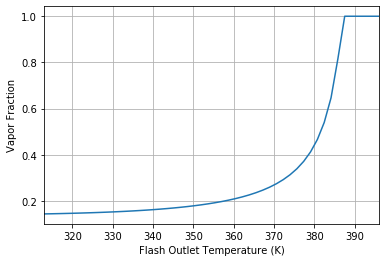

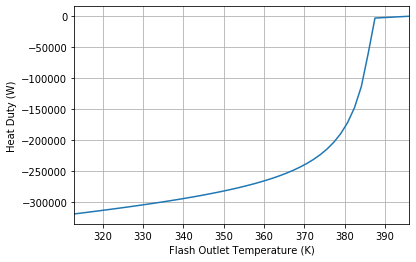

In [9]:
# Solve the model for a range of flash outlet temperatures - 313 K - 396 K
import numpy as np
temp_range = list(np.linspace(313,396))

# List of vapor fraction values
vapor_frac = []

# List of heat duty values
heat_duty = []

# Simulate the flash model in the range of flash outlet temperatures
for t in temp_range:
    m.fs.flash.vap_outlet.temperature.fix(t)
    res = solver.solve(m)
    if res.solver.termination_condition == "optimal":
        frac = value(m.fs.flash.vap_outlet.flow_mol[0])/value(m.fs.flash.inlet.flow_mol[0])
        hduty = value(m.fs.flash.heat_duty[0])
        vapor_frac.append(frac)
        heat_duty.append(hduty)

# Plot the vapor fraction values as a function of flash outlet temperature
import matplotlib.pyplot as plt
plt.plot(temp_range,vapor_frac)
plt.xlim(313,396)
plt.xlabel("Flash Outlet Temperature (K)")
plt.ylabel("Vapor Fraction")
plt.grid()
plt.show()

# Plot the heat duty values as a function of flash outlet temperature
plt.plot(temp_range,heat_duty)
plt.xlim(313,396)
plt.xlabel("Flash Outlet Temperature (K)")
plt.ylabel("Heat Duty (W)")
plt.grid()
plt.show()